In [1]:
%load_ext autoreload

import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s') # NOTSET, DEBUG, INFO, WARN, ERROR, CRITICAL

from JPAS_DA.data import data_loaders
from JPAS_DA.data import generate_toy_data
from JPAS_DA.models import model_building_tools
from JPAS_DA.training import training_tools
from JPAS_DA.training import save_load_tools

import os
import torch
import numpy as np

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

from JPAS_DA.utils import plotting_utils
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('default')
plt.close('all')
font, rcnew = plotting_utils.matplotlib_default_config()
mpl.rc('font', **font)
plt.rcParams.update(rcnew)
plt.style.use('tableau-colorblind10')
%matplotlib widget

from JPAS_DA.utils import aux_tools
aux_tools.set_seed(42)

/tmp/ipykernel_38954/550949071.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_dict = {cls: plt.cm.get_cmap("tab10")(i) for i, cls in enumerate(np.arange(n_classes))}


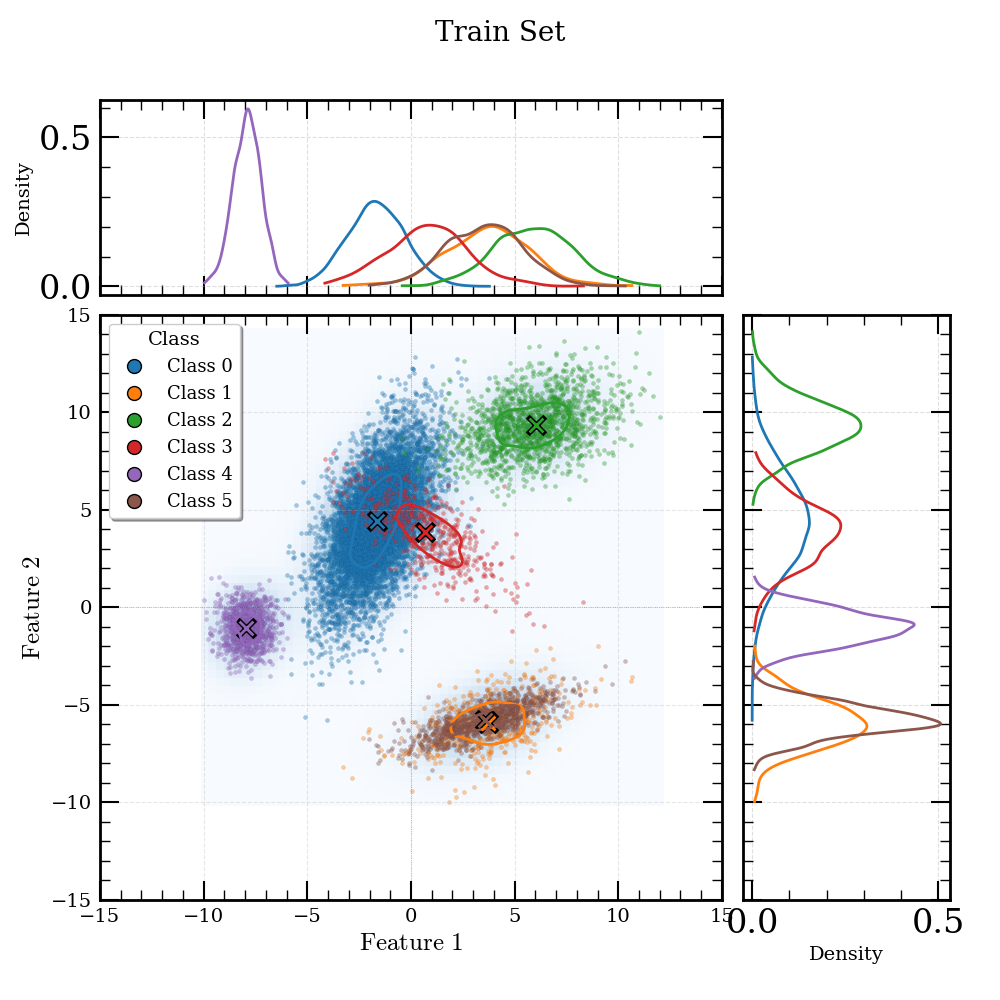

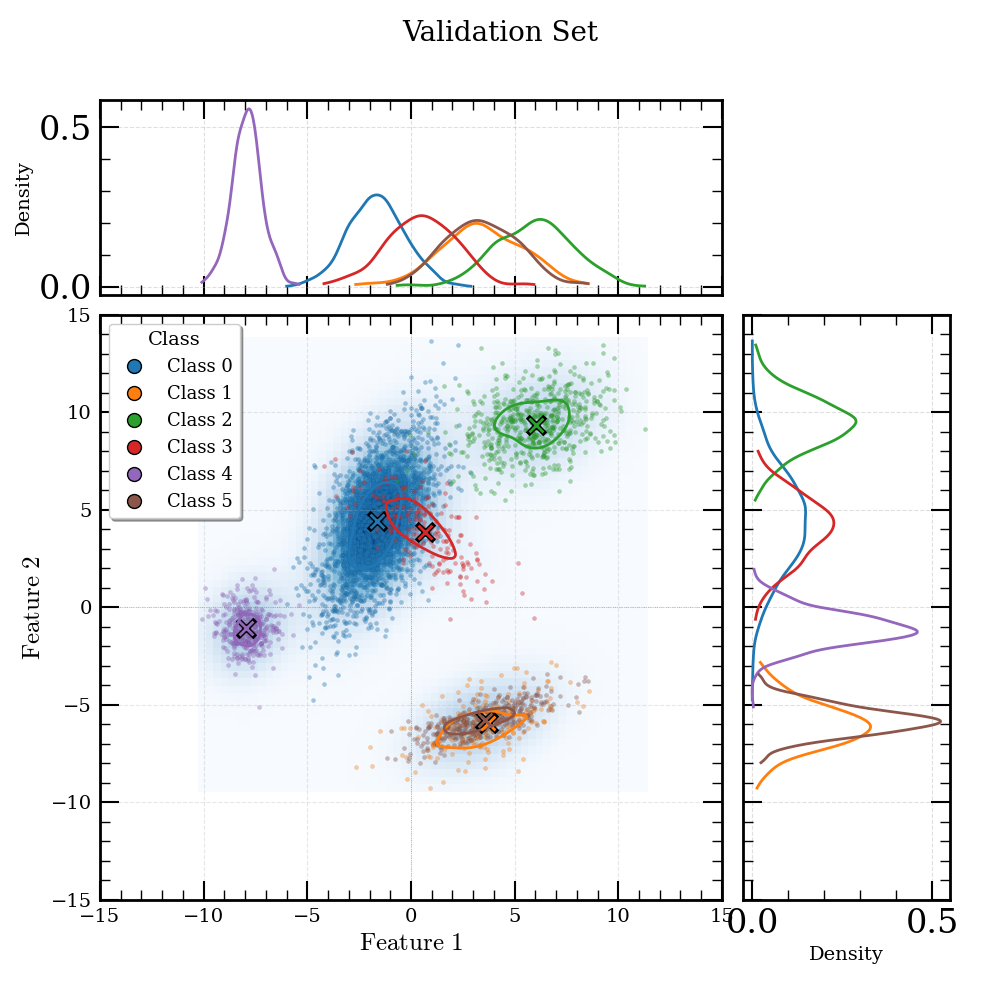

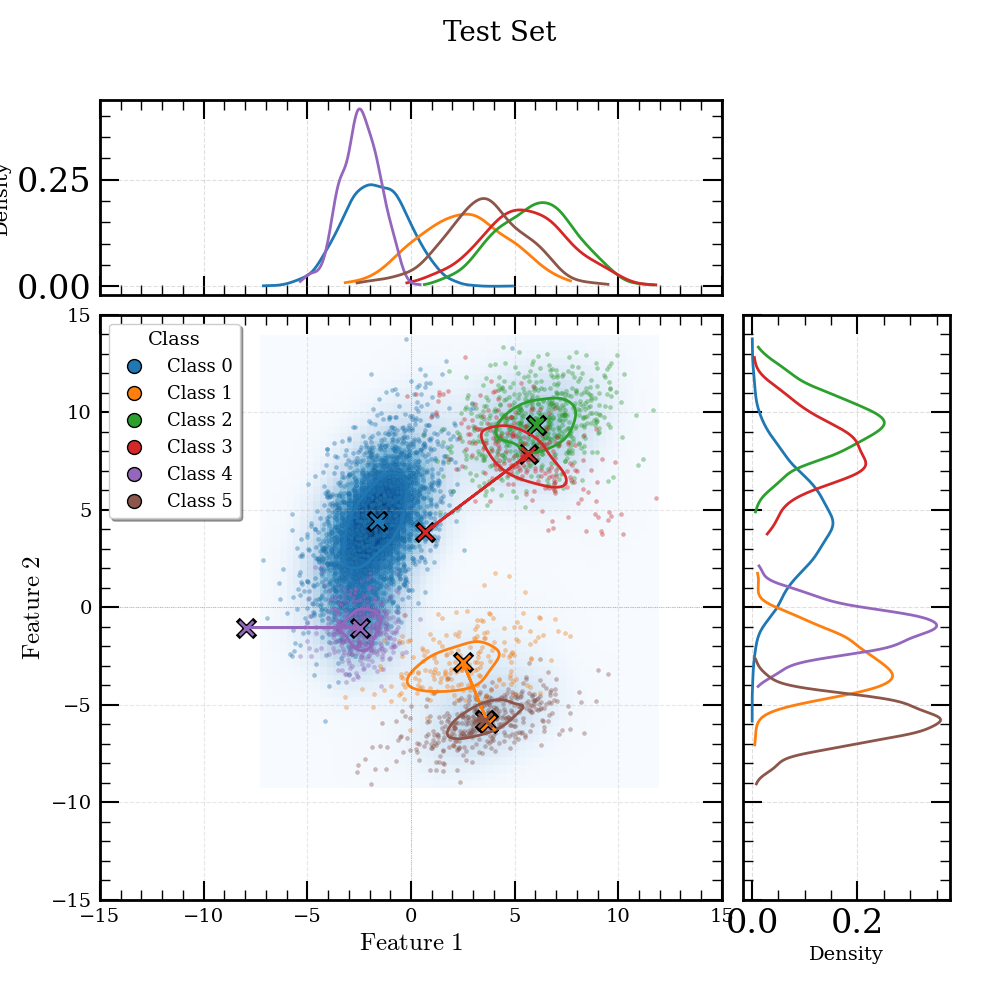

In [2]:
# === Shared Parameters ===
n_classes = 6
n_features = 2
class_center_range = [(-10, 10), (-10, 10)]
cov_scale_range = (0.1, 1.1)
class_proportions = np.array([0.55, 0.05, 0.15, 0.05, 0.1, 0.1])
assert np.isclose(class_proportions.sum(), 1.0)

# === Sample Sizes and Seeds ===
n_samples_train = 10000
n_samples_val = 4000
n_samples_test = 4000
n_samples_train_DA = 4000
n_samples_val_DA = 4000

seed_structure = 1     # Used to define centers and covariances
seed_train = 42        # Ensures different train/val/test samples
seed_val = 13
seed_test = 0
seed_train_DA = 2
seed_val_DA = 3
seed_shift = 4

# === Generate fixed shared structure for train/val ===
shared_centers, shared_covs = generate_toy_data.generate_centers_covs(n_classes, n_features, class_center_range, cov_scale_range, seed_structure)

# === Generate train/val sets with different seeds but same structure ===
xx_train, yy_train, train_counts = generate_toy_data.generate_dataset_from_structure(n_samples_train, shared_centers, shared_covs, class_proportions, seed=seed_train)
xx_val, yy_val, val_counts = generate_toy_data.generate_dataset_from_structure(n_samples_val, shared_centers, shared_covs, class_proportions, seed=seed_val)

# === Generate test set with shifted centers and covs ===
shifted_centers, shifted_covs = generate_toy_data.shift_centers_covs(shared_centers, shared_covs, center_shift=1.0, cov_shift=0.5, seed=seed_shift)

shifted_centers = np.array([
[-1.65955991,  4.40648987],
[ 2.50439001, -2.81095501],
[ 6.01489137,  9.36523151],
[ 5.6633057 ,  7.83754228],
[-2.43547987, -1.04212948],
[ 3.57671066, -5.76743768]
])
xx_test, yy_test, test_counts = generate_toy_data.generate_dataset_from_structure(n_samples_test, shifted_centers, shifted_covs, class_proportions, seed=seed_test)
xx_train_DA, yy_train_DA, _ = generate_toy_data.generate_dataset_from_structure(n_samples_val_DA, shifted_centers, shifted_covs, class_proportions, seed=seed_val_DA)
xx_val_DA, yy_val_DA, _ = generate_toy_data.generate_dataset_from_structure(n_samples_val_DA, shifted_centers, shifted_covs, class_proportions, seed=seed_val_DA)


# === Visualize sets ===
color_dict = {cls: plt.cm.get_cmap("tab10")(i) for i, cls in enumerate(np.arange(n_classes))}

fig1, ax_main1 = plotting_utils.plot_2d_classification_with_kde(xx_train["OBS"], yy_train["SPECTYPE_int"], title="Train Set", class_color_dict=color_dict)
for i in range(n_classes):
    ax_main1.scatter(shared_centers[i, 0], shared_centers[i, 1], marker="x", color='black', s=160, linewidth=4, zorder=1)
    ax_main1.scatter(shared_centers[i, 0], shared_centers[i, 1], marker="x", color=color_dict[i], s=100, linewidth=2, zorder=2)
ax_main1.set_xlim(-15, 15)
ax_main1.set_ylim(-15, 15)
plt.show()

fig2, ax_main2 = plotting_utils.plot_2d_classification_with_kde(xx_val["OBS"], yy_val["SPECTYPE_int"], title="Validation Set", class_color_dict=color_dict)
for i in range(n_classes):
    ax_main2.scatter(shared_centers[i, 0], shared_centers[i, 1], marker="x", color='black', s=160, linewidth=4, zorder=1)
    ax_main2.scatter(shared_centers[i, 0], shared_centers[i, 1], marker="x", color=color_dict[i], s=100, linewidth=2, zorder=2)
ax_main2.set_xlim(-15, 15)
ax_main2.set_ylim(-15, 15)
plt.show()

fig3, ax_main3 = plotting_utils.plot_2d_classification_with_kde(xx_test["OBS"], yy_test["SPECTYPE_int"], title="Test Set", class_color_dict=color_dict)
for i in range(n_classes):
    ax_main3.scatter(shared_centers[i, 0], shared_centers[i, 1], marker="x", color='black', s=160, linewidth=4, zorder=1)
    ax_main3.scatter(shared_centers[i, 0], shared_centers[i, 1], marker="x", color=color_dict[i], s=100, linewidth=2, zorder=2)
for i in range(n_classes):
    ax_main3.scatter(shifted_centers[i, 0], shifted_centers[i, 1], marker="x", color='black', s=160, linewidth=4, zorder=1)
    ax_main3.scatter(shifted_centers[i, 0], shifted_centers[i, 1], marker="x", color=color_dict[i], s=100, linewidth=2, zorder=2)
for i in range(n_classes):
    delta = shifted_centers[i] - shared_centers[i]
    ax_main3.arrow(shared_centers[i, 0], shared_centers[i, 1], delta[0], delta[1], color=color_dict[i], linewidth=2, head_width=0.2, length_includes_head=True)
ax_main3.set_xlim(-15, 15)
ax_main3.set_ylim(-15, 15)
plt.show()

In [3]:
path_load = "/home/dlopez/Documents/Projects/JPAS_Domain_Adaptation/SAVED_models/06_example_model"

In [4]:
if path_load is None:

    dset_train = data_loaders.DataLoader(xx_train, yy_train, normalize=True, provided_normalization=None)

    means = dset_train.means
    stds = dset_train.stds
    
    dset_val = data_loaders.DataLoader(xx_val, yy_val, normalize=True, provided_normalization=(means, stds))
    dset_test = data_loaders.DataLoader(xx_test, yy_test, normalize=True, provided_normalization=(means, stds))

else:
    means, stds = save_load_tools.load_means_stds(path_load)

    dset_train = data_loaders.DataLoader(xx_train_DA, yy_train_DA, normalize=True, provided_normalization=(means, stds))
    dset_val = data_loaders.DataLoader(xx_val_DA, yy_val_DA, normalize=True, provided_normalization=(means, stds))
    dset_test = data_loaders.DataLoader(xx_test, yy_test, normalize=True, provided_normalization=(means, stds))

2025-05-17 15:16:37,408 - INFO - ├── 💿 Initializing DataLoader object with 4000 samples...
2025-05-17 15:16:37,408 - INFO - ├── ✔ Finished Initialization. Class distribution: [0: 2200 (55.00%), 1: 200 (5.00%), 2: 600 (15.00%), 3: 200 (5.00%), 4: 400 (10.00%), 5: 400 (10.00%)]
2025-05-17 15:16:37,408 - INFO - ├── 💿 Initializing DataLoader object with 4000 samples...
2025-05-17 15:16:37,408 - INFO - ├── ✔ Finished Initialization. Class distribution: [0: 2200 (55.00%), 1: 200 (5.00%), 2: 600 (15.00%), 3: 200 (5.00%), 4: 400 (10.00%), 5: 400 (10.00%)]
2025-05-17 15:16:37,409 - INFO - ├── 💿 Initializing DataLoader object with 4000 samples...
2025-05-17 15:16:37,409 - INFO - ├── ✔ Finished Initialization. Class distribution: [0: 2200 (55.00%), 1: 200 (5.00%), 2: 600 (15.00%), 3: 200 (5.00%), 4: 400 (10.00%), 5: 400 (10.00%)]


In [5]:
path_load_encoder = os.path.join(path_load, "model_encoder.pt") if path_load else None
path_load_downstream = os.path.join(path_load, "model_downstream.pt") if path_load else None

# hidden_layers_encoder = [32, 16, 16]
# dropout_rates_encoder = [0.01, 0.01, 0.01]
# output_dim_encoder = 2

# hidden_layers_downstream = [8, 8, 8]
# dropout_rates_downstream = [0.01, 0.01, 0.01]

In [6]:
if path_load_encoder:
    assert os.path.isfile(path_load_encoder), f"File does not exist: {path_load_encoder}"
    config_encoder, model_encoder = save_load_tools.load_model_from_checkpoint(
        path_load_encoder, model_building_tools.create_mlp
    )
else:
    xx, _ = dset_train(batch_size=1)
    config_encoder = {
        'input_dim': xx.shape[-1],
        'hidden_layers': hidden_layers_encoder,
        'dropout_rates': dropout_rates_encoder,
        'output_dim': output_dim_encoder,
        'use_batchnorm': False,
        'use_layernorm_at_output': False,
        'init_method': 'xavier'
    }
    model_encoder = model_building_tools.create_mlp(**config_encoder)

if path_load_downstream:
    assert os.path.isfile(path_load_downstream), f"File does not exist: {path_load_downstream}"
    config_downstream, model_downstream = save_load_tools.load_model_from_checkpoint(
        path_load_downstream, model_building_tools.create_mlp
    )
else:
    config_downstream = {
        'input_dim': output_dim_encoder,
        'hidden_layers': hidden_layers_downstream,
        'dropout_rates': dropout_rates_downstream,
        'output_dim': n_classes,
        'use_batchnorm': False,
        'use_layernorm_at_output': False,
        'init_method': 'xavier'
    }
    model_downstream = model_building_tools.create_mlp(**config_downstream)

/home/dlopez/Documents/Projects/JPAS_Domain_Adaptation/JPAS_DA/training/save_load_tools.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path_che

In [7]:
print(model_encoder)
print(model_downstream)

Sequential(
  (0): Linear(in_features=2, out_features=32, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.01, inplace=False)
  (3): Linear(in_features=32, out_features=16, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.01, inplace=False)
  (6): Linear(in_features=16, out_features=16, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.01, inplace=False)
  (9): Linear(in_features=16, out_features=2, bias=True)
)
Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.01, inplace=False)
  (3): Linear(in_features=8, out_features=8, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.01, inplace=False)
  (6): Linear(in_features=8, out_features=8, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.01, inplace=False)
  (9): Linear(in_features=8, out_features=6, bias=True)
)


In [8]:
sampling_strategy = "true_random"
freeze_downstream_model = True

path_save = '/home/dlopez/Documents/Projects/JPAS_Domain_Adaptation/SAVED_models'
path_save += "/07_example_model_DA"

In [9]:
if sampling_strategy == "true_random":
    counts = dset_train.class_counts
    total_samples = np.sum(counts)
    weights = total_samples / (n_classes * counts)
    class_weights = torch.tensor(weights, dtype=torch.float32)
if sampling_strategy == "class_random":
    class_weights = torch.tensor(np.ones(n_classes), dtype=torch.float32)

loss_function_dict = {
    "type": "CrossEntropyLoss",
    "sampling_strategy": sampling_strategy,
    "class_weights": class_weights
}

In [10]:
min_val_loss = training_tools.train_model(
    dset_train=dset_train,
    model_encoder=model_encoder,
    model_downstream=model_downstream,
    loss_function_dict=loss_function_dict,
    freeze_downstream_model=freeze_downstream_model,
    dset_val=dset_val,
    NN_epochs=300,
    NN_batches_per_epoch=32,
    batch_size=128,
    batch_size_val=len(dset_val.yy[list(dset_val.yy.keys())[0]]),
    lr=0.005,
    weight_decay=0.001,
    clip_grad_norm=10.0,
    seed_mode="deterministic",
    seed=0,
    path_save=path_save,
    config_encoder=config_encoder,
    config_downstream=config_downstream
)

2025-05-17 15:16:38,151 - INFO - Directory '/home/dlopez/Documents/Projects/JPAS_Domain_Adaptation/SAVED_models/07_example_model_DA' already exists.
2025-05-17 15:16:39,386 - INFO - Overwriting '/home/dlopez/Documents/Projects/JPAS_Domain_Adaptation/SAVED_models/07_example_model_DA'...
2025-05-17 15:16:39,386 - INFO - Directory '/home/dlopez/Documents/Projects/JPAS_Domain_Adaptation/SAVED_models/07_example_model_DA' has been overwritten.
/home/dlopez/miniconda3/envs/VE/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
2025-05-17 15:16:39,788 - INFO - 🚀 Starting training loop...
2025-05-17 15:16:39,788 - INFO - 
📚 Epoch 1/300
2025-05-17 15:16:39,870 - INFO - 📊 Epoch Eval | train_loss: 2.885591, val_loss: 2.885591, lr: 5.00e-03
2025-05-17 15:16:39,870 - INFO - ✅ New best model!
2025-05-17 15:16:39,871 - INFO - Saving to: /home/dlopez/Documents/Projects/JPAS_D

/home/dlopez/Documents/Projects/JPAS_Domain_Adaptation/JPAS_DA/utils/plotting_utils.py:469: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


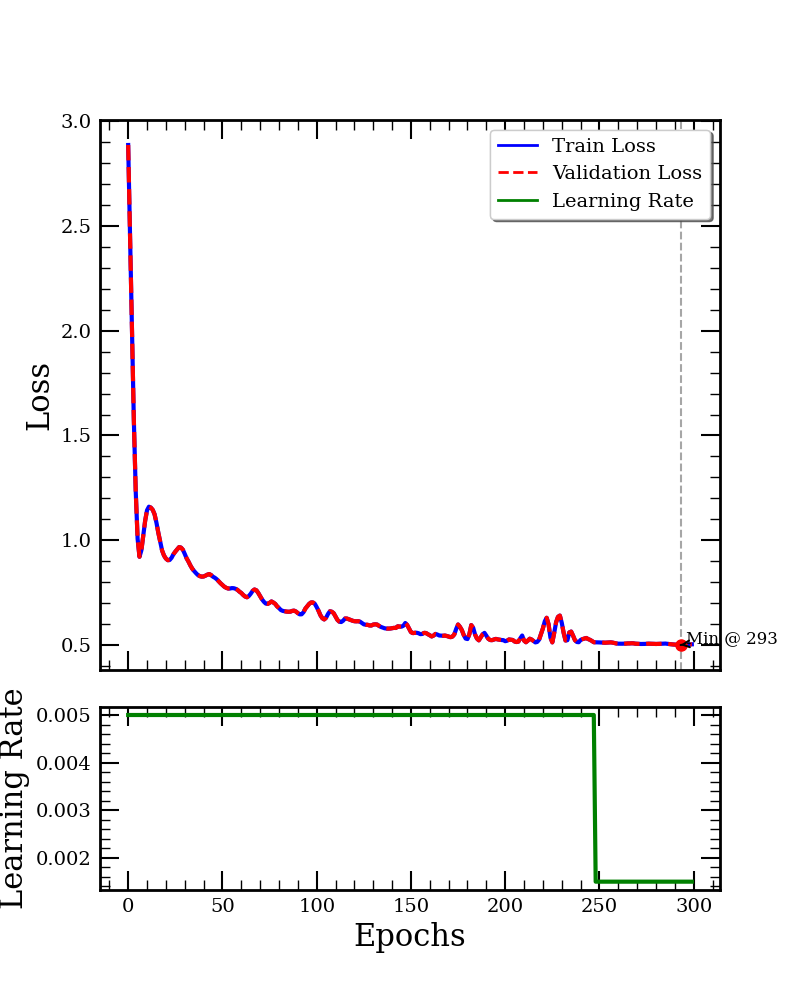

In [11]:
plotting_utils.plot_training_curves(path_save)

In [12]:
device = next(model_encoder.parameters()).device

In [13]:
unique_labels = dset_train.class_labels

# === Generate meshgrid from training data bounds ===
x_min, x_max = -15, 15
y_min, y_max = -15, 15

grid_res = 256
xx_vals = np.linspace(x_min, x_max, grid_res)
yy_vals = np.linspace(y_min, y_max, grid_res)
xx_mesh, yy_mesh = np.meshgrid(xx_vals, yy_vals)

grid_points = np.stack([xx_mesh.ravel(), yy_mesh.ravel()], axis=1)
grid_points = (grid_points - dset_train.means[0]) / dset_train.stds[0]
xx_grid = torch.tensor(grid_points, dtype=torch.float32, device=device)

# === Compute class probabilities and predicted class ===
with torch.no_grad():
    features = model_encoder(xx_grid)
    logits = model_downstream(features)
    yy_pred_P = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()
    yy_pred = np.argmax(yy_pred_P, axis=1)

/tmp/ipykernel_38954/2168995091.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_base = plt.cm.get_cmap("tab10")


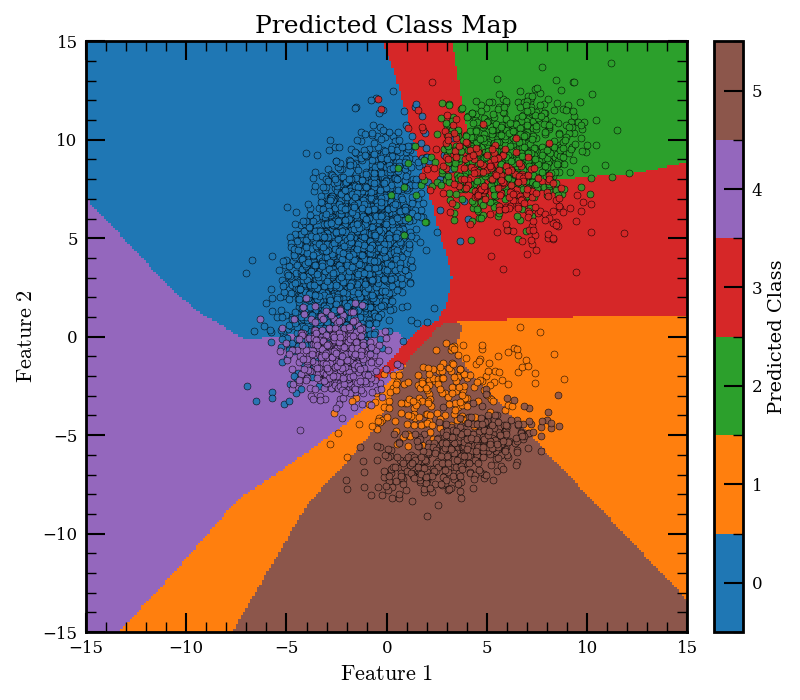

In [14]:
# === Reshape to grid ===
Z = yy_pred.reshape(grid_res, grid_res).astype(float)  # cast to float for gouraud shading

fig, ax = plt.subplots(figsize=(8, 7))

# Discrete colormap (but visually smoothed by gouraud)
unique_labels = np.unique(Z.astype(int))
cmap_base = plt.cm.get_cmap("tab10")
class_color_dict = {label: cmap_base(label) for label in unique_labels}
colors = [class_color_dict[label] for label in unique_labels]
cmap = mpl.colors.ListedColormap(colors)

# Use boundaries to align ticks to color blocks
boundaries = np.arange(len(unique_labels) + 1) - 0.5
norm = mpl.colors.BoundaryNorm(boundaries, ncolors=len(unique_labels))
pcm = ax.pcolormesh(xx_mesh, yy_mesh, Z, cmap=cmap, norm=norm, shading='nearest')

# Overlay training points using the same colormap
for ii, label in enumerate(unique_labels):
    mask = dset_train.yy["SPECTYPE_int"] == label
    tmp = (dset_train.xx["OBS"][mask] * dset_train.stds[0]) + dset_train.means[0]
    ax.scatter(tmp[:, 0], tmp[:, 1], s=25, alpha=0.9, color=class_color_dict[label],
               edgecolor='black', linewidth=0.4)

# Styling
ax.set_title("Predicted Class Map", fontsize=18)
ax.set_xlabel(r"$\mathrm{Feature~1}$", fontsize=16)
ax.set_ylabel(r"$\mathrm{Feature~2}$", fontsize=16)
ax.tick_params(labelsize=12)

# Colorbar (optional: no strict boundaries here due to gouraud shading)
cbar = fig.colorbar(pcm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label("Predicted Class", fontsize=14)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_yticks(np.arange(len(unique_labels)))
cbar.ax.set_yticklabels(unique_labels)

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()

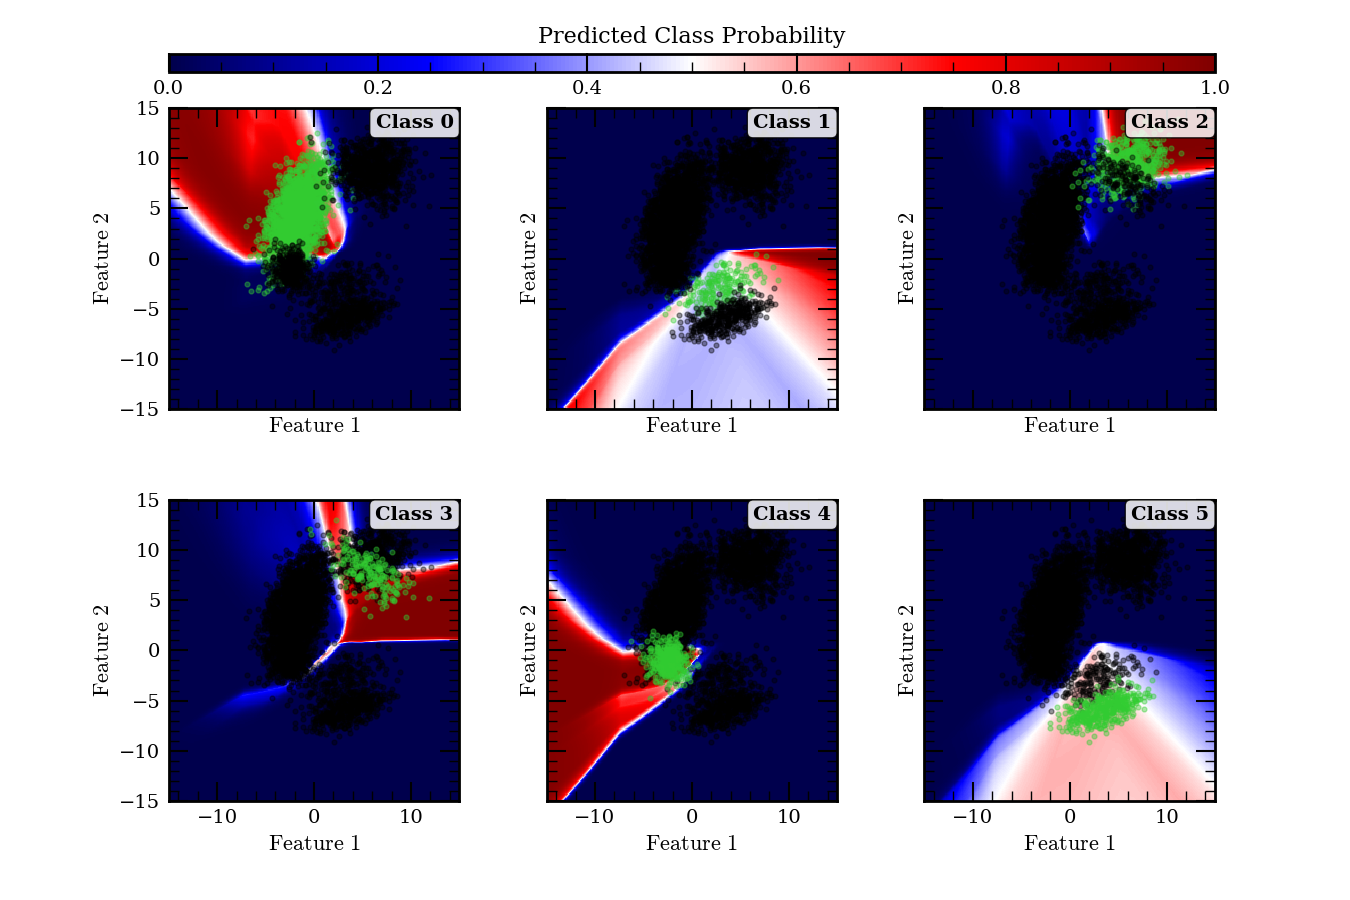

In [15]:
# === Reshape to grid ===
Z = yy_pred_P.reshape(grid_res, grid_res, n_classes)

# Determine a roughly square grid layout
n_cols = np.ceil(np.sqrt(n_classes)).astype(int)
n_rows = np.ceil(n_classes / n_cols).astype(int)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(4.5 * n_cols, 4.5 * n_rows), sharex=True, sharey=True)
axs = np.array(axs).reshape(n_rows, n_cols)  # Ensure 2D array for indexing

vmin, vmax = 0.0, 1.0
cmap = "seismic"
pcm = None

for idx in range(n_classes):
    row, col = divmod(idx, n_cols)
    ax = axs[row, col]

    pcm = ax.pcolormesh(xx_mesh, yy_mesh, Z[..., idx], cmap=cmap, shading='auto', vmin=vmin, vmax=vmax)

    # Annotate class index
    ax.text(
        0.98, 0.98, f"Class {idx}", transform=ax.transAxes, ha='right', va='top', fontsize=14, fontweight='bold',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.85)
    )

    ax.set_xlabel(r"$\mathrm{Feature~1}$", fontsize=16)
    ax.set_ylabel(r"$\mathrm{Feature~2}$", fontsize=16)
    ax.tick_params(axis='both', labelsize=14)

    for jj, label in enumerate(unique_labels):
        mask = dset_train.yy["SPECTYPE_int"] == label
        tmp = (dset_train.xx["OBS"][mask] * dset_train.stds[0]) + dset_train.means[0]
        color = 'limegreen' if idx == jj else 'k'
        ax.scatter(tmp[:, 0], tmp[:, 1], s=12, alpha=0.4, color=color)

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    
# Hide unused axes
for idx in range(n_classes, n_rows * n_cols):
    row, col = divmod(idx, n_cols)
    axs[row, col].axis("off")

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# === Shared horizontal colorbar at the top ===
pos0 = axs[0, 0].get_position()
posn = axs[-1, -1 if n_classes % n_cols != 0 else n_cols - 1].get_position()
cbar_ax = fig.add_axes([pos0.x0, pos0.y1 + 0.04, posn.x1 - pos0.x0, 0.02])
cbar = fig.colorbar(pcm, cax=cbar_ax, orientation='horizontal')
cbar.ax.set_title("Predicted Class Probability", fontsize=16, pad=8)
cbar.ax.tick_params(labelsize=14)

plt.show()

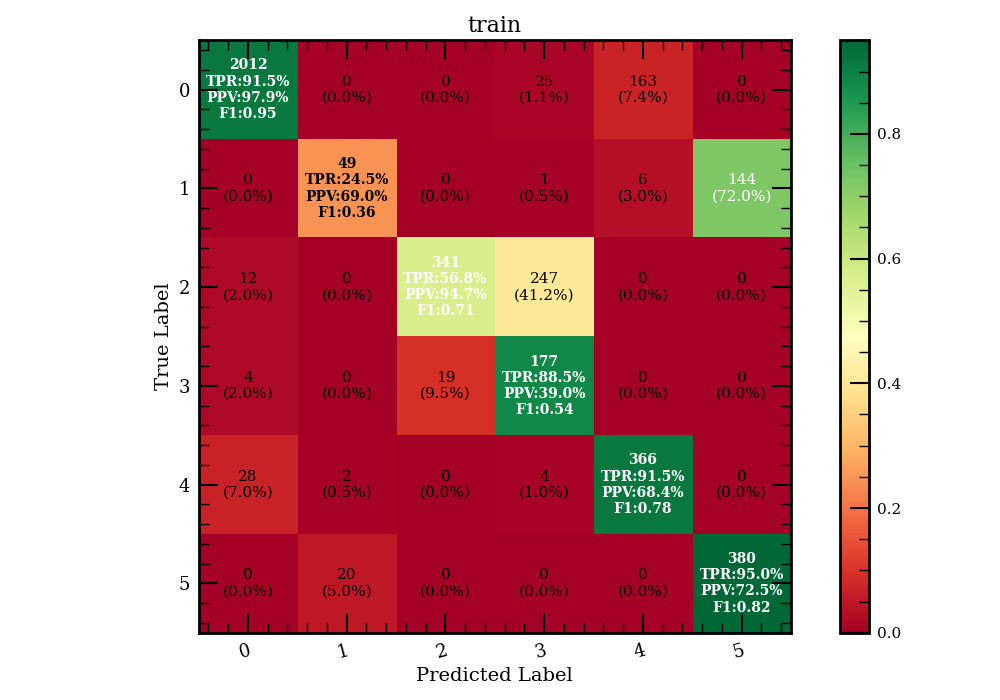

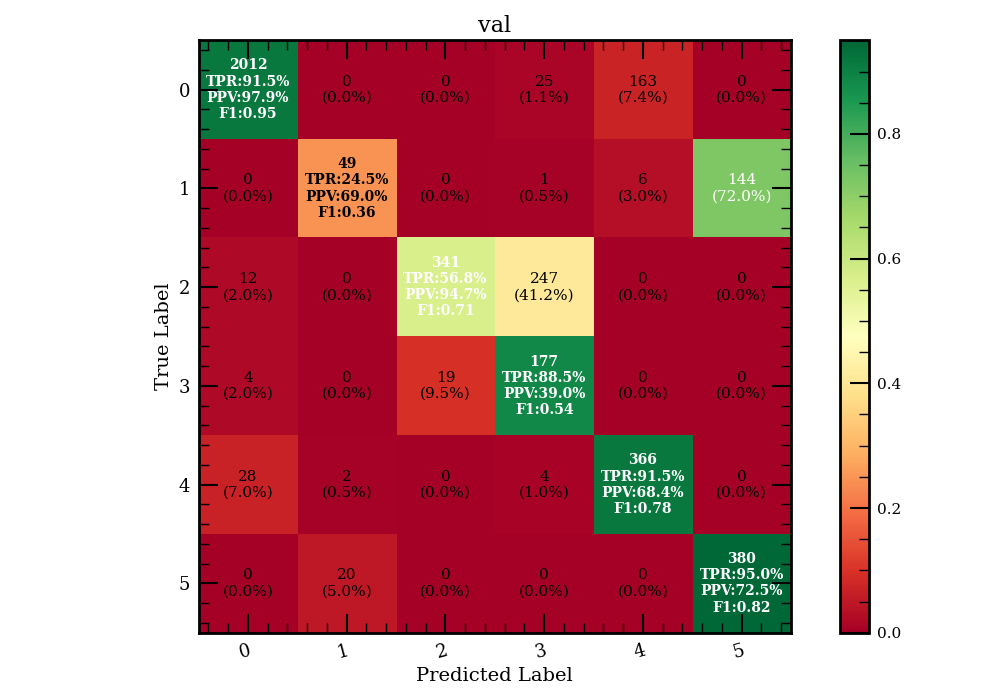

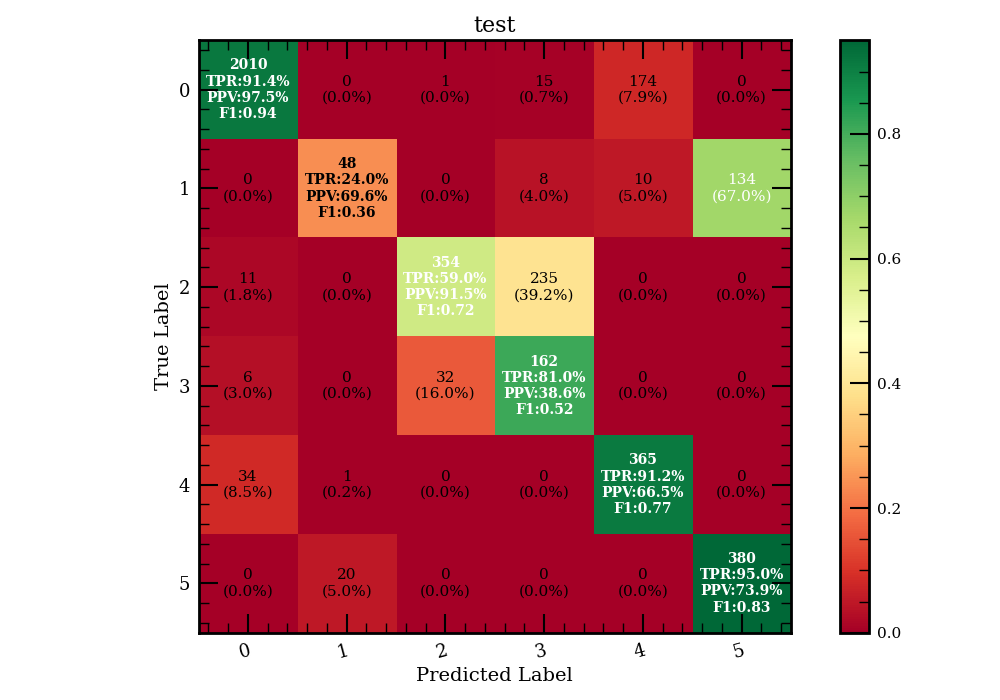

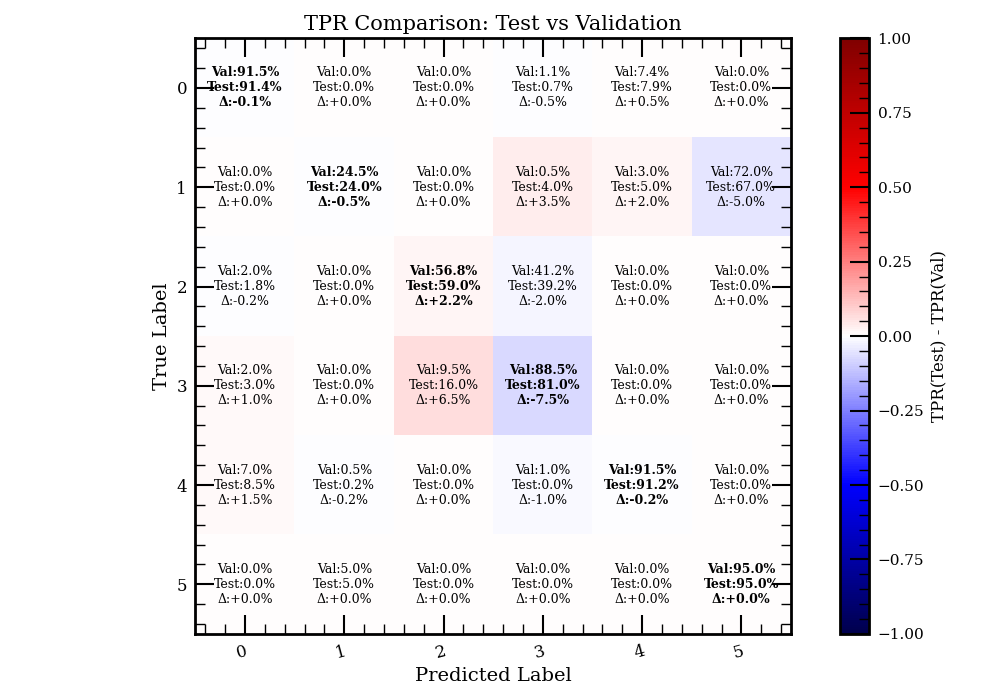


=== val vs test Metrics ===
Metric                       val        test    Δ (test - val)
--------------------------------------------------------------
Accuracy                  0.8313      0.8297           -0.0015
Macro F1                  0.6940      0.6902           -0.0039
Macro TPR                 0.7463      0.7360           -0.0103
Macro Precision           0.7359      0.7292           -0.0066
Macro AUROC               0.9698      0.9660           -0.0038
ECE                       0.0439      0.0478            0.0039


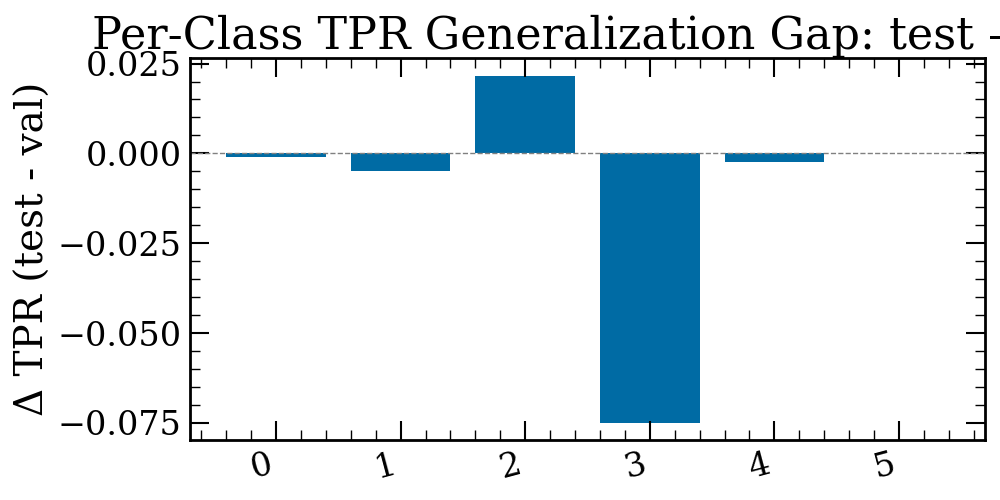

In [16]:
# === Train ===
xx_train, yy_true_train = dset_train(batch_size=dset_train.NN_xx, seed=0, sampling_strategy="true_random", to_torch=True, device=device)

with torch.no_grad():
        features_train = model_encoder(xx_train)
        logits = model_downstream(features_train)
yy_pred_P_train = torch.nn.functional.softmax(logits, dim=1)
yy_pred_P_train = yy_pred_P_train.cpu().numpy()
yy_pred_train = np.argmax(yy_pred_P_train, axis=1)
yy_true_train = yy_true_train.cpu().numpy()
xx_train = xx_train.cpu().numpy()
features_train = features_train.cpu().numpy()

plotting_utils.plot_confusion_matrix(
    yy_true_train, yy_pred_P_train,
    class_names=np.arange(n_classes),
    cmap=plt.cm.RdYlGn, title="train"
)


# === Val ===
xx_val, yy_true_val = dset_val(batch_size=dset_val.NN_xx, seed=0, sampling_strategy="true_random", to_torch=True, device=device)

with torch.no_grad():
        features_val = model_encoder(xx_val)
        logits = model_downstream(features_val)
yy_pred_P_val = torch.nn.functional.softmax(logits, dim=1)
yy_pred_P_val = yy_pred_P_val.cpu().numpy()
yy_pred_val = np.argmax(yy_pred_P_val, axis=1)
yy_true_val = yy_true_val.cpu().numpy()
xx_val = xx_val.cpu().numpy()
features_val = features_val.cpu().numpy()

plotting_utils.plot_confusion_matrix(
    yy_true_val, yy_pred_P_val,
    class_names=np.arange(n_classes),
    cmap=plt.cm.RdYlGn, title="val"
)


# === Test ===
xx_test, yy_true_test = dset_test(batch_size=dset_test.NN_xx, seed=0, sampling_strategy="true_random", to_torch=True, device=device)

with torch.no_grad():
        features_test = model_encoder(xx_test)
        logits = model_downstream(features_test)
yy_pred_P_test = torch.nn.functional.softmax(logits, dim=1)
yy_pred_P_test = yy_pred_P_test.cpu().numpy()
yy_pred_test = np.argmax(yy_pred_P_test, axis=1)
yy_true_test = yy_true_test.cpu().numpy()
xx_test = xx_test.cpu().numpy()
features_test = features_test.cpu().numpy()

plotting_utils.plot_confusion_matrix(
    yy_true_test, yy_pred_P_test,
    class_names=np.arange(n_classes),
    cmap=plt.cm.RdYlGn, title="test"
)


# === Compare Val VS Test ===
plotting_utils.compare_TPR_confusion_matrices(
    yy_true_val,
    yy_pred_P_val,
    yy_true_test,
    yy_pred_P_test,
    class_names=np.arange(n_classes),
    figsize=(10, 7),
    cmap='seismic',
    title='TPR Comparison: Test vs Validation'
)

plotting_utils.compare_sets_performance(
    yy_true_val, yy_pred_P_val,
    yy_true_test, yy_pred_P_test,
    class_names=np.arange(n_classes),
    name_1="val",
    name_2="test"
)

/tmp/ipykernel_38954/2171384357.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10")


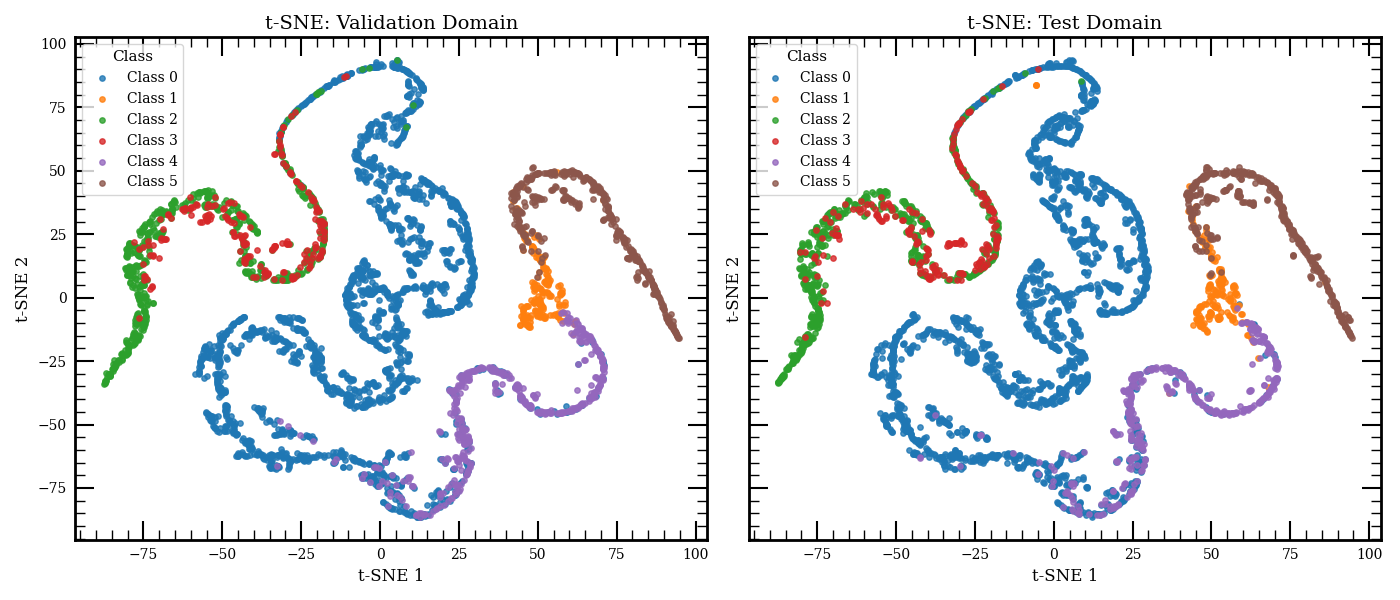

In [17]:
# t-SNE visualization of domain shift (Validation vs Test) in side-by-side subplots
from sklearn.manifold import TSNE

# --- Data preparation ---
X_val = features_val
X_test = features_test
y_val = yy_true_val
y_test = yy_true_test

X_all = np.vstack([X_val, X_test])
y_all = np.concatenate([y_val, y_test])

# --- t-SNE embedding ---
tsne = TSNE(n_components=2, perplexity=30, init='pca', random_state=42)
X_all_tsne = tsne.fit_transform(X_all)

X_val_tsne = X_all_tsne[:len(X_val)]
X_test_tsne = X_all_tsne[len(X_val):]

# --- Consistent color mapping ---
unique_classes = np.unique(y_all)
cmap = plt.cm.get_cmap("tab10")
class_color_dict = {cls: cmap(i) for i, cls in enumerate(unique_classes)}

# --- Visualization ---
fig, (ax_val, ax_test) = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

# Validation plot
for cls in unique_classes:
    idx = np.where(y_val == cls)[0]
    ax_val.scatter(X_val_tsne[idx, 0], X_val_tsne[idx, 1],
                   color=class_color_dict[cls], label=f"Class {cls}",
                   s=15, alpha=0.8)
ax_val.set_title("t-SNE: Validation Domain", fontsize=14)
ax_val.set_xlabel("t-SNE 1", fontsize=12)
ax_val.set_ylabel("t-SNE 2", fontsize=12)
ax_val.tick_params(labelsize=10)
ax_val.legend(title="Class", fontsize=10, title_fontsize=11)

# Test plot
for cls in unique_classes:
    idx = np.where(y_test == cls)[0]
    ax_test.scatter(X_test_tsne[idx, 0], X_test_tsne[idx, 1],
                    color=class_color_dict[cls], label=f"Class {cls}",
                    s=15, alpha=0.8)
ax_test.set_title("t-SNE: Test Domain", fontsize=14)
ax_test.set_xlabel("t-SNE 1", fontsize=12)
ax_test.set_ylabel("t-SNE 2", fontsize=12)
ax_test.tick_params(labelsize=10)
ax_test.legend(title="Class", fontsize=10, title_fontsize=11)

plt.tight_layout()
plt.show()